In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.neighbors import kneighbors_graph
from scipy.spatial.distance import pdist, squareform
import cvxpy as cp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from sklearn import datasets, manifold

np.random.seed(42)
N = 100
X, c = datasets.make_swiss_roll(n_samples=100)
T = np.concatenate([np.eye(3), np.zeros((3,3))], axis=0)
T += 0.03 * np.random.randn(6,3)
X = T @ X.T

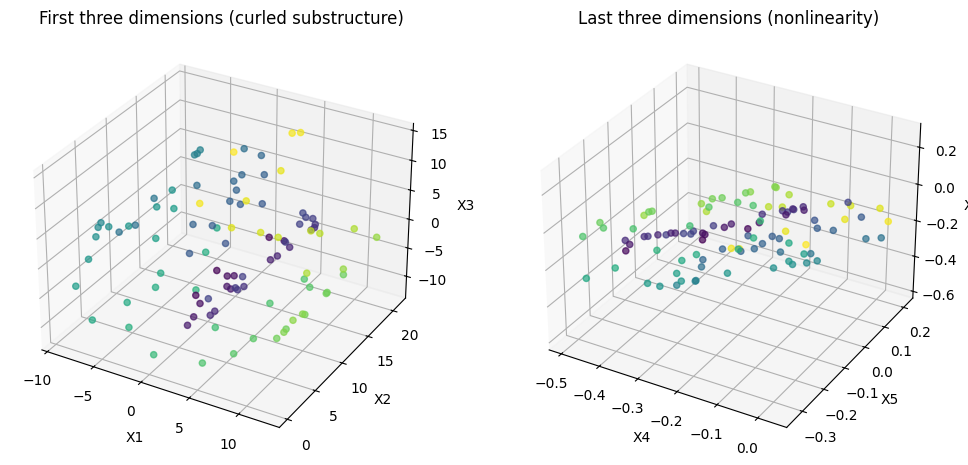

In [2]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[0], X[1], X[2], c=c, alpha=0.7)
ax1.set_title('First three dimensions (curled substructure)')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('X3')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X[3], X[4], X[5], c=c, alpha=0.7)
ax2.set_title('Last three dimensions (nonlinearity)')
ax2.set_xlabel('X4')
ax2.set_ylabel('X5')
ax2.set_zlabel('X6')

plt.show()


In [3]:
import numpy as np
import cvxpy as cp
from sklearn.neighbors import kneighbors_graph

# generate distance matrix 
k = 3
D = np.sum((X[:, :, None] - X[:, None, :])**2, axis=0)
pairs = set()
for i in range(N):
    neighbors = np.argsort(D[i])[1:k+1]
    pairs.update({(min(i, j), max(i, j)) for j in neighbors})

B = cp.Variable((N, N), symmetric=True)
constraints = [B >> 0]
for i, j in pairs:
    constraints.append(B[i, i] + B[j, j] - 2 * B[i, j] == D[i][j])

objective = cp.Maximize(cp.trace(B) - cp.sum(B) / N)
problem = cp.Problem(objective, constraints)
problem.solve()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


65399.39220563239

In [4]:
mds = manifold.MDS(2, random_state=42)
X_mds = mds.fit_transform(X.T).T

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [5]:
U, Sigma, _ = np.linalg.svd(B.value)
X_sdp = U @ np.diag(np.sqrt(Sigma))
X_sdp = mds.fit_transform(X_sdp).T

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


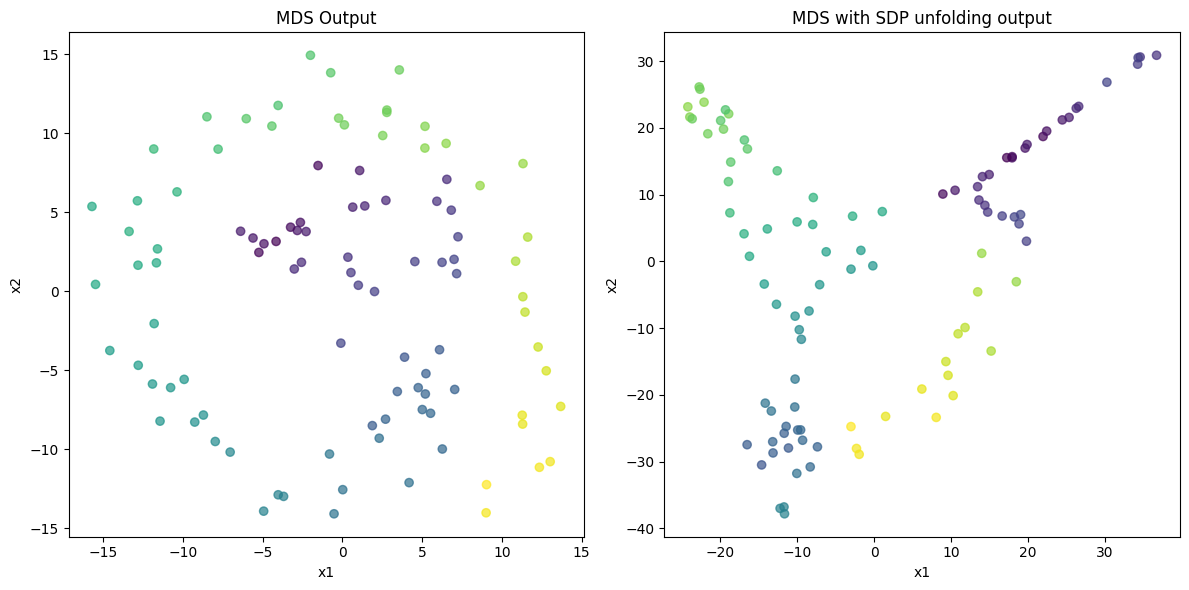

In [6]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(X_mds[0], X_mds[1], c=c, alpha=0.7)
plt.title('MDS Output')
plt.xlabel('x1')
plt.ylabel('x2')

plt.subplot(122)
plt.scatter(X_sdp[0], X_sdp[1], c=c, alpha=0.7)
plt.title('MDS with SDP unfolding output')
plt.xlabel('x1')
plt.ylabel('x2')

plt.tight_layout()
plt.show()
